# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [134]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [135]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [136]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-09-17 09:00:00+09:00,44751.839844,44827.058594,44656.000000,44694.578125,0,0.0,0.0
2025-09-17 09:15:00+09:00,44695.558594,44695.558594,44612.070312,44630.628906,0,0.0,0.0
2025-09-17 09:30:00+09:00,44642.160156,44678.148438,44613.031250,44677.820312,0,0.0,0.0
2025-09-17 09:45:00+09:00,44677.980469,44801.488281,44676.539062,44782.011719,0,0.0,0.0
2025-09-17 10:00:00+09:00,44777.160156,44871.671875,44777.160156,44833.261719,0,0.0,0.0
2025-09-17 10:15:00+09:00,44826.699219,44968.289062,44814.410156,44961.468750,0,0.0,0.0
2025-09-17 10:30:00+09:00,44950.128906,44993.230469,44919.378906,44976.339844,0,0.0,0.0
2025-09-17 10:45:00+09:00,44979.050781,45033.339844,44969.609375,44974.351562,0,0.0,0.0
2025-09-17 11:00:00+09:00,44974.121094,45016.980469,44966.640625,45014.320312,0,0.0,0.0


## 前日終値の取得

In [137]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-09-10 00:00:00+09:00    43837.671875
2025-09-11 00:00:00+09:00    44372.500000
2025-09-12 00:00:00+09:00    44768.121094
2025-09-17 00:00:00+09:00    44858.859375
Name: Close, dtype: float64


Date
2025-09-12 00:00:00+09:00    44768.121094
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [138]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-16.28


## ローソク足チャート（小さいサイズ）

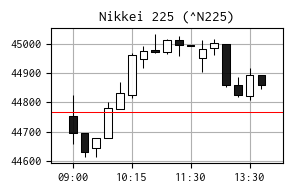

In [139]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()